# **Single Player Game**

# **Loading data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
working_dir = '/content/drive/MyDrive/drawGuesswer'
data_path = '/content/drive/MyDrive/drawGuesswer/data'

In [ ]:
categories = [i[:-4] for i in os.listdir(os.path.join(working_dir, 'data'))]
label_dict = {i:j[:-4] for i, j in enumerate(os.listdir(os.path.join(working_dir, 'data')))}
num_classes = len(categories)
label_dict

{0: 'ambulance',
 1: 'fish',
 2: 'apple',
 3: 'axe',
 4: 'banana',
 5: 'basket',
 6: 'carrot',
 7: 'bed',
 8: 'airplane',
 9: 'cat'}

In [ ]:
classes = {}
for i, category in enumerate(os.listdir(data_path)):
    data = pd.read_csv(os.path.join(data_path, category))
    classes[category[:-4]] = data[['drawing', 'word']]


In [ ]:
data = pd.concat([classes[i][:35000] for i in classes])
val_data = pd.concat([classes[i][35001:35021] for i in classes])
val_label = val_data['word'].values.tolist()
labels = data['word']
data = data['drawing']

# **Visualising data**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import ast

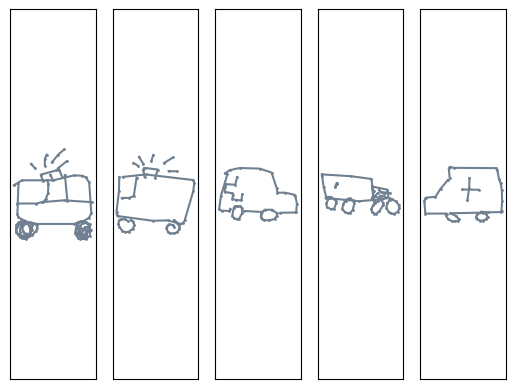

In [ ]:
for i in range(5):
    picture = ast.literal_eval(data.values[i])
    for x, y in picture:
        plt.subplot(1, 5, (i-0)+1)
        plt.plot(x,y,'-o',markersize=1,color='slategray')
        plt.xticks([])
        plt.yticks([])
    plt.gca().invert_yaxis()
    plt.axis('equal')

# Function for extracting image

In [ ]:
img_size = 64
def get_image(data, lw=7, time_color=False):
    data = ast.literal_eval(data)
    image = np.zeros((300, 300), np.uint8)
    for t, s in enumerate(data):
        for i in range(len(s[0])-1):
            color = 255-min(t,10)*15 if time_color else 255
            _ = cv2.line(image, (s[0][i] + 15, s[1][i] + 15),
                       (s[0][i+1] + 15, s[1][i+1] + 15), color, lw)
    return cv2.resize(image,(img_size, img_size))

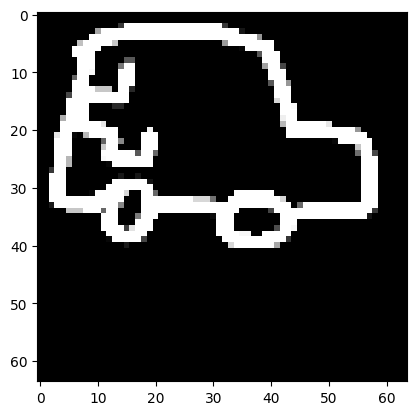

In [ ]:
plt.imshow(cv2.cvtColor(get_image(data.values[2], 11), cv2.COLOR_BGR2RGB))

# Create image arrays

In [ ]:
images = []
for i in data:
    images.extend(get_image(i, 11))

In [ ]:
val_images = []
for i in val_data['drawing']:
    val_images.extend(get_image(i, 11))

# One Hot Encoding labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
label = labels.values.tolist()
label = np.array(label).reshape(-1,1)
images = np.array(images)
ohe.fit(label)
label

array([['ambulance'],
       ['ambulance'],
       ['ambulance'],
       ...,
       ['cat'],
       ['cat'],
       ['cat']], dtype='<U9')

In [ ]:
val_label = np.array(val_label).reshape(-1,1)
val_label = ohe.transform(val_label).toarray()
label = ohe.transform(label).toarray()
label

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
#@title Saving data in binary format (Optional)
'''
import pickle

if os.path.exists(os.path.join(working_dir, 'images.bin')):
    with open(os.path.join(working_dir, 'images.bin'), 'rb') as f:
        images = pickle.load(f)
else:
    with open(os.path.join(working_dir, 'images.bin'), 'wb') as f:
        pickle.dump(images, f)

if os.path.exists(os.path.join(working_dir, 'label.bin')):
    with open(os.path.join(working_dir, 'label.bin'), 'rb') as f:
        label = pickle.load(f)
else:
    with open(os.path.join(working_dir, 'label.bin'), 'wb') as f:
        pickle.dump(label, f)

if os.path.exists(os.path.join(working_dir, 'val_images.bin')):
    with open(os.path.join(working_dir, 'val_images.bin'), 'rb') as f:
        val_images = pickle.load(f)
else:
    with open(os.path.join(working_dir, 'val_images.bin'), 'wb') as f:
        pickle.dump(val_images, f)

if os.path.exists(os.path.join(working_dir, 'val_label.bin')):
    with open(os.path.join(working_dir, 'val_label.bin'), 'rb') as f:
        val_label = pickle.load(f)
else:
    with open(os.path.join(working_dir, 'val_label.bin'), 'wb') as f:
        pickle.dump(val_label, f)
'''

In [ ]:
import numpy as np
img_size = 64

val_images = np.array(val_images).reshape(-1, 64, 64, 1)

images = images.reshape(-1, img_size, img_size, 1)
print('image shape: ', images.shape)
print('label shape: ', label.shape)

image shape:  (350000, 64, 64, 1)
label shape:  (350000, 10)


# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images, label, train_size=0.8, random_state=42)
print('x_train: ', type(x_train), x_train.dtype, x_train.shape)
print('y_train: ', type(y_train), y_train.dtype, y_train.shape)

x_train:  <class 'numpy.ndarray'> uint8 (280000, 64, 64, 1)
y_train:  <class 'numpy.ndarray'> float64 (280000, 10)


# Initialising GPU for Training

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, Dropout, GlobalMaxPooling2D, Dense, MaxPooling2D, Activation

def cnn_model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=.02))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model

model = cnn_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        832       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 196)       156996    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 28, 28, 196)       0         
                                                        

# Fitting the data

In [ ]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                  patience=4,verbose=2,factor=.75)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(working_dir, 'drawGuesser.h5'),
    monitor='val_accuracy',
    save_best_only='True',
    verbose=1
)

history = model.fit(x_train, y_train, batch_size=64, epochs=15, validation_data=(val_images, val_label),
          callbacks=[lr_reduction, model_checkpoint], verbose=1)

Epoch 1/15
4375/4375 [==============================] - ETA: 0s - loss: 0.7751 - accuracy: 0.8035
Epoch 1: val_accuracy improved from -inf to 0.91500, saving model to /content/drive/MyDrive/drawGuesswer/drawGuesser.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4375/4375 [==============================] - 85s 18ms/step - loss: 0.7751 - accuracy: 0.8035 - val_loss: 0.2603 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 2/15
4373/4375 [============================>.] - ETA: 0s - loss: 0.4139 - accuracy: 0.8767
Epoch 2: val_accuracy improved from 0.91500 to 0.94500, saving model to /content/drive/MyDrive/drawGuesswer/drawGuesser.h5
4375/4375 [==============================] - 78s 18ms/step - loss: 0.4139 - accuracy: 0.8767 - val_loss: 0.2132 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 3/15
4375/4375 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8849
Epoch 3: val_accuracy did not improve from 0.94500
4375/4375 [==============================] - 78s 18ms/step - loss: 0.3896 - accuracy: 0.8849 - val_loss: 0.1839 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/15
4375/4375 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8895
Epoch 4: val_accuracy did not improve from 0.94500
4375/4375 [==========================

# Plotting accuracy and loss from history

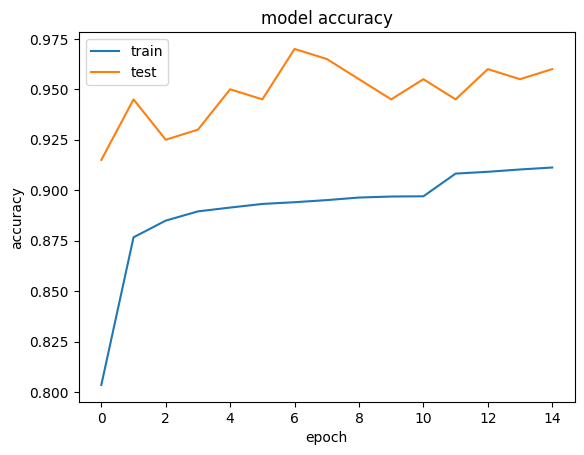

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

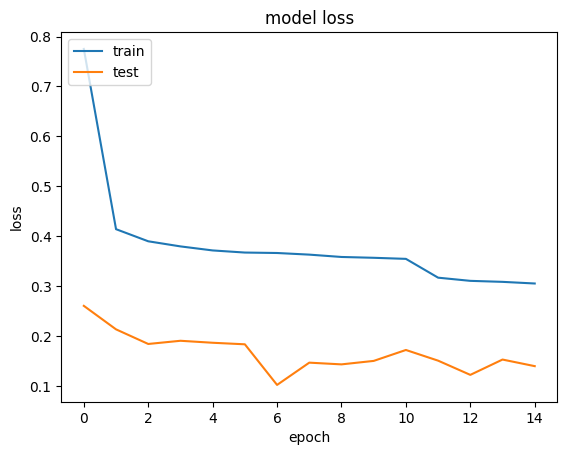

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(f"Final validation loss and accuracy: {model.evaluate(val_images, val_label)}")

7/7 [==============================] - 0s 5ms/step - loss: 0.1394 - accuracy: 0.9600
Final validation loss and accuracy: [0.1394139677286148, 0.9599999785423279]


# Make decoder

In [ ]:
decoder = {'airplane': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'ambulance': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'apple': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'axe': [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'banana': [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'basket': [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
 'bed': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 'carrot': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 'cat': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
 'fish': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]}


In [ ]:
model = tf.keras.models.load_model(os.path.join(working_dir, 'drawGuesser.h5'))

In [ ]:
np.expand_dims(val_images[0], 0).shape

(1, 64, 64, 1)

In [ ]:
predictions = model.predict(np.expand_dims(val_images[0], 0))
for i in predictions:
    print(list(decoder.keys())[np.argmax(i, axis=0)])

1/1 [==============================] - 0s 174ms/step
ambulance


# Quantised model conversion

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save Quantised model

In [ ]:
open("drawGuesser_lite.tflite", "wb").write(tflite_model)

1483124